In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Import 
import os 
import time
import numpy as np
import pandas as pd
from scipy import stats
import neuropythy as ny
import matplotlib.pyplot as plt
import scipy.sparse.csgraph as cs
import importlib

# personal import 
from plot_utils import plotly_template, prf_ecc_pcm_plot
from math_utils import weighted_regression, weighted_nan_percentile, weighted_nan_median



In [2]:
# Settings 
subject_id = 111312
hemis = 'lh'
hemis = ['lh','rh']
roi = 'V1'
rois = ['V1', 'V2', 'V3']
plot_groups = [['V1'],['V2'],['V3']]
roi_code = {'V1':1, 
            'V2':2, 
            'V3':3}

num_ecc_pcm_bins = 6
max_ecc = 8

In [3]:
# Import DF 
tsv_dir = '/home/jovyan/projects/pRF-project_NH2025/data/tsv'
tsv_fn = '{}/{}_prf_parameters.tsv'.format(tsv_dir, subject_id)


prf_CM_df = pd.read_table(tsv_fn, sep="\t")

## Make DF

In [4]:
ecc_bins = np.concatenate(([0],np.linspace(0.50, 1, num_ecc_pcm_bins)**2 * max_ecc))
for num_roi, roi in enumerate(rois):
    df_roi = prf_CM_df.loc[(prf_CM_df.roi == roi)]
    df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
    df_ecc_pcm_bin = pd.DataFrame()
    df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
    df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
    df_ecc_pcm_bin['prf_ecc_bins'] = df_bins.apply(lambda x: weighted_nan_median(x['prf_ecc'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin['prf_pcm_bins_median'] = df_bins.apply(lambda x: weighted_nan_median(x['pRF_CM'].values, x['prf_r2'].values)).values
    df_ecc_pcm_bin['prf_r2_bins_median'] = np.array(df_bins['prf_r2'].median())
    df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 75)).values
    df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = df_bins.apply(lambda x: weighted_nan_percentile(x['pRF_CM'].values, x['prf_r2'].values, 25)).values
    if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
    else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])  



## Final plot 

In [5]:
# Figure settings
roi_colors = {'V1': 'rgb(243, 231, 155)', 
              'V2': 'rgb(250, 196, 132)', 
              'V3': 'rgb(248, 160, 126)'}
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

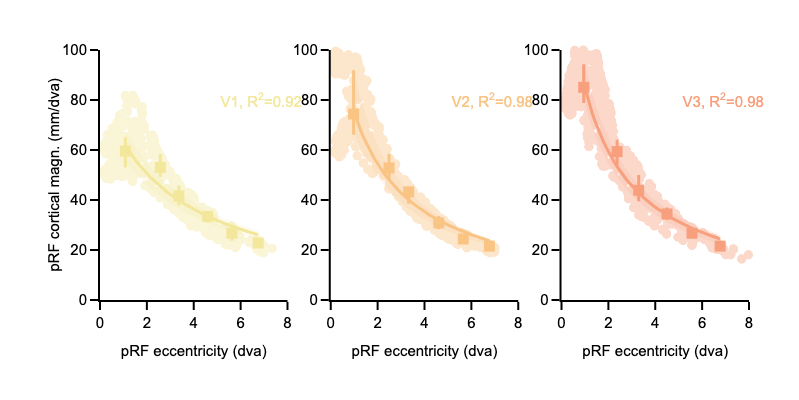

In [6]:
fig = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm_bins, 
                       data_pcm_raw=prf_CM_df, 
                       fig_width=1000, 
                       fig_height=400, 
                       rois=rois, 
                       roi_colors=roi_colors, 
                       plot_groups=plot_groups, 
                       max_ecc=max_ecc)

fig_dir = '/home/jovyan/projects/pRF-project_NH2025/figures/'
os.makedirs(fig_dir, exist_ok=True)
fig.write_image("{}/ecc_pcm.pdf".format(fig_dir))

fig.show()
